# Project - Cdiscount Image Classification



# Data ingestion
The primary training set is a 57GB bson file, having ~15 Million images (180x180 images in Base64 format) of ~7.06 Million products. We have imported the dataset into a MongoDB instance on a VPS, so we were able to query among the records.
We have chosen 100 categories, which overally consist of ~246K images of ~110K products.


## Dataset preparation

First we need to ensure that the "gdown" library is installed and accessible in the environment and download the train_medium data from Google Drive,

In [ ]:
! pip install gdown && gdown --id 1F6Xf4yiYxeFEN6qhrL3YBNs0Vhx0bXJ1

## Chunk reader higher level function
Below I've defined a function which you can call with another function as input, it will call the input function as many times with chunks of the dataset till the whole dataset is passed to it.
### Note: In the input function, you shouldn't store the passed chunks in a global variable, or your program will crash due to a memory congestion.
Remember, each image is a 180x180x3 3D np.array object, so the size of each record is ~97KB, therefore the size of the dataset when converted to np.array object equals ~24 GB which will not fit into your memory nor in the colab associated memory.

In [107]:
import tensorflow as tf

df = pd.read_csv("train_shuffled_100cat.csv", header=3, nrows=1)
img = df.at[0, "image"]
print(img)
print(tf.io.decode_base64(img))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAC0ALQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAG+Yn95fzo8xP7y/nWdRV8pz+2fY0fMT+8v50eYn95fzrOoo5Q9s+xo+Yn95fzo8xP7y/nWdRRyh7Z9jR8xP7y/nR5if3l/Os6ijlD2z7

InvalidArgumentError: Invalid character found in base64. [Op:DecodeBase64]

In [101]:
import pandas as pd

import base64
from PIL import Image
import base64
import io
import numpy as np

def run_func_by_chunks(func, chunk_size=10 ** 4, num_runs=-1):
    chunk_num=0
    rets = ()
    with pd.read_csv("train_shuffled_100cat.csv", header=3, chunksize=chunk_size) as reader:
        for chunk in reader:
            
            chunk["image"] = chunk["image"].apply(
                lambda x: np.array(Image.open(io.BytesIO(base64.b64decode(x)))).reshape(180,180,3)
            )
            
            rets+=(func(np.array(chunk), chunk_num),)
            if num_runs==chunk_num+1:
                return rets
            chunk_num+=1
    return rets
    

In [102]:
def log_chunks_and_sum_size(ch, ch_num):
    print("*", ch_num, ":", ch[0,1].shape)
    return ch.shape[0]
x = run_func_by_chunks(log_chunks_and_sum_size, chunk_size=1, num_runs=-1)
print(sum(x))

InvalidArgumentError: Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]

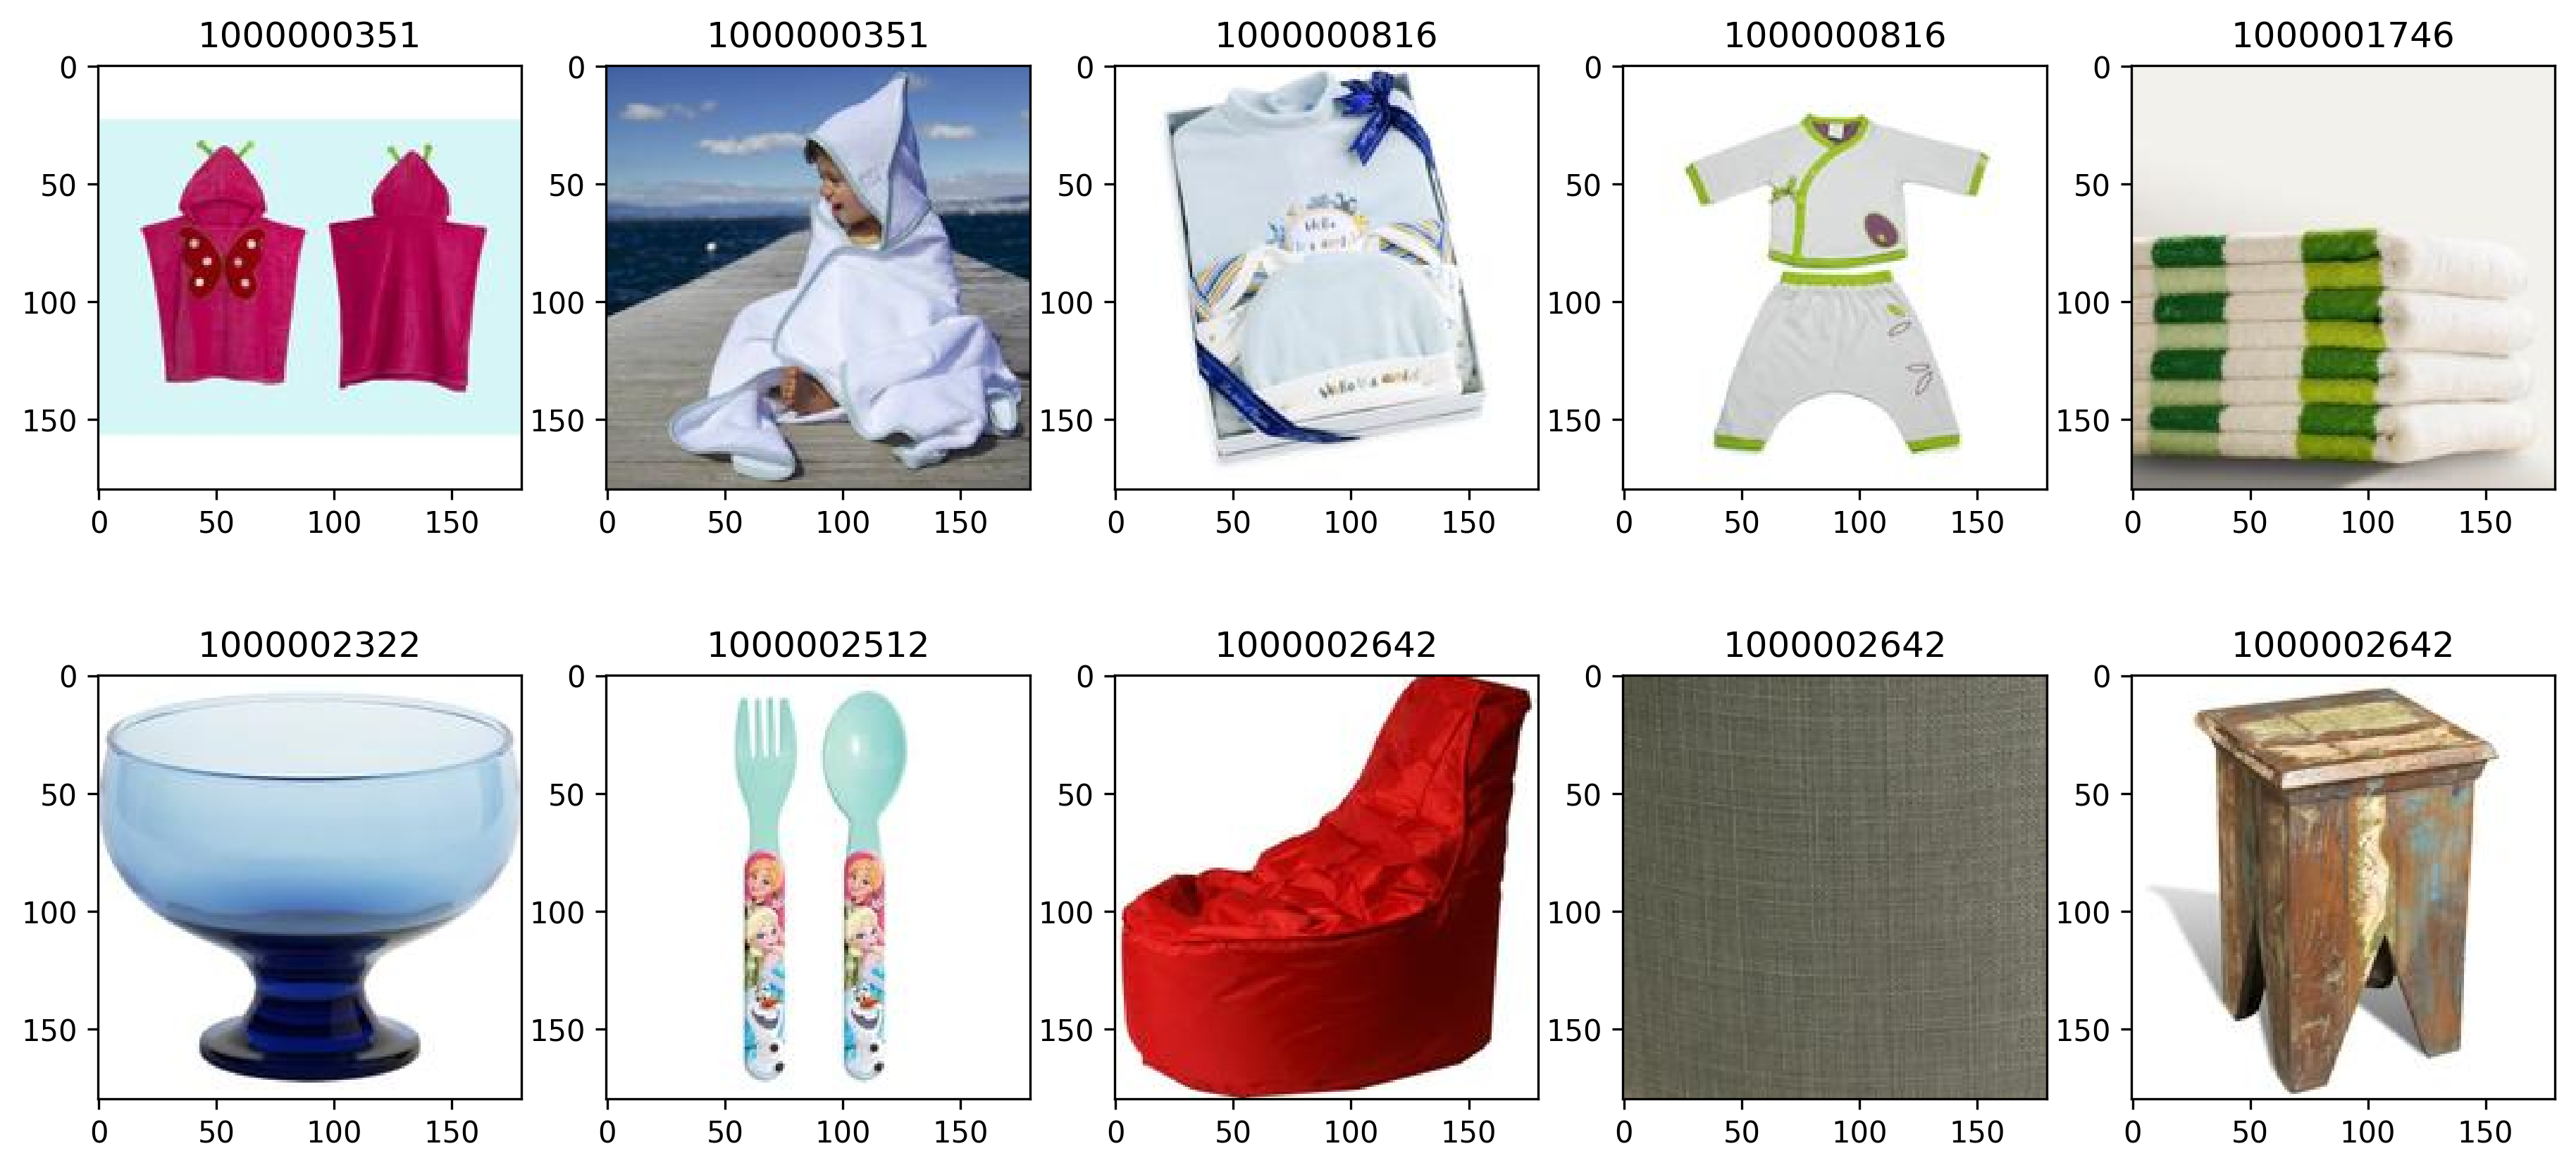

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize = (15,7), dpi= 300)
def plot_from_chunk(ch, ch_num):
    plt.subplot(2, 5, ch_num+1)
    plt.title(ch[0, 2])
    plt.imshow(ch[0,1])
run_by_chunks(plot_from_chunk, chunk_size=1000, num_runs=10)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(df["image"].values[100000-1])

In [ ]:
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct



import keras
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

from collections import defaultdict
from tqdm import *

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import sys

## 1. Load your data

In [ ]:
(X_dev, Y_dev), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

print(X_dev.shape)
print(X_test.shape)

## 2. Explore your data 

Showing 10 samples from dev set

In [ ]:
plt.figure(figsize=(12, 6), dpi=1000)
indexes = np.arange(len(X_dev))
np.random.shuffle(indexes)
for idx in range(10):
  plt.subplot(2, 5, idx + 1)
  plt.imshow(X_dev[indexes[idx]])
plt.show()

#Splitting dev set into train/val set

In [ ]:
splitter = int(len(X_dev) * .8) #= splitting point of train/val set

X_train = X_dev[indexes[:splitter]]
Y_train = Y_dev[indexes[:splitter]]

X_val = X_dev[indexes[splitter:]]
Y_val = Y_dev[indexes[splitter:]]

print("X_train:", X_train.shape)
print("X_val:", X_val.shape)

## 3. Represent your labels using one hot encoding

In [ ]:
Y_train_oh = tf.keras.utils.to_categorical(Y_train)
Y_val_oh = tf.keras.utils.to_categorical(Y_val)
Y_test_oh = tf.keras.utils.to_categorical(Y_test)

print("Y_train",  Y_train[:3])
print("Y_train_oh:",  Y_train_oh[:3])
print("Y_val",  Y_val[:3])
print("Y_val_oh:",  Y_val_oh[:3])
print("Y_test",  Y_test[:3])
print("Y_test_oh:",  Y_test_oh[:3])


#Scaling outputs
X_train_sc = X_train
X_val_sc = X_val
X_test_sc = X_test


## 4. Data scaling and Data augmentation

In [ ]:
# Experiment with different data scaling methods

scaling_mode = 2  #= 0: disabled, 1: min-max normalization, 2: standardization

X_train = X_train_sc 
X_val = X_val_sc 
X_test = X_test_sc 

if scaling_mode == 1: 
  x_train_min = X_train.min()
  x_train_max = X_train.max()
  X_train = ( X_train - x_train_min ) / (x_train_max - x_train_min)
  x_val_min = X_val.min()
  x_val_max = X_val.max()
  X_val = ( X_val - x_val_min ) / (x_val_max - x_val_min)
  x_test_min = X_test.min()
  x_test_max = X_test.max()
  X_test = ( X_test - x_test_min ) / (x_test_max - x_test_min)
elif scaling_mode == 2:
  x_train_mean = X_train.mean()
  x_train_std = X_train.std()
  print(x_train_mean, x_train_std)
  X_train = ( X_train - x_train_mean ) / x_train_std
  X_val = ( X_val - x_train_mean ) / x_train_std
  X_test = ( X_test - x_train_mean ) / x_train_std
  

    





In [ ]:
# Create your data augmentation object to improve training
# set your batch size

batch_size = 32
gen_params = {"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":50,"width_shift_range":0.1,"height_shift_range":0.1,\
              "shear_range":0.1, "zoom_range":0.1,"horizontal_flip":True,"fill_mode":'nearest',\
               "cval": 0}
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)

train_gen.fit(X_train,seed = 1)
val_gen.fit(X_val, seed = 1)

train_flow = train_gen.flow(X_train,Y_train_oh,batch_size = batch_size)
val_flow = val_gen.flow(X_val,Y_val_oh,batch_size = batch_size)

In [ ]:
# plt.figure(figsize=(12, 6), dpi=1000)
# for i in range(10):
#   plt.subplot(2, 5, i + 1)
#   plt.imshow(X_train[i])

# plt.show()


plt.figure(figsize=(12, 6), dpi=1000)
Xbatch,Ybatch = train_flow.__getitem__(1)
Xbatch_min = Xbatch.min(axis=1, keepdims=True)
Xbatch_max = Xbatch.max(axis=1, keepdims=True)
print(Xbatch)
# Xbatch = ( Xbatch - Xbatch_min ) / (Xbatch_max - Xbatch_min)
for ii in range(batch_size):
    plt.subplot(7,5,ii+1)
    plt.imshow(Xbatch[ii].reshape(32, 32, 3), cmap=plt.get_cmap('gray'))
               
               
plt.show()

# sys.exit("Error message")





## Fully Connected Model

## 5. Define your  model, cost function, optimizer, learning rate

In [ ]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
def my_model_fully_connected():
    
    return

## 6. Define your callbacks (save your model, patience, etc.)

In [ ]:
model_name_fcn = "team_(team number)_FCN.h5"

# define your callbacks
# remember that you need to save the weights of your best model!

## 7. Train your model

In [ ]:
# train your model - decide for how many epochs

## 8. Test your model

In [ ]:
model.load_weights(model_name_fcn)
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

## Convolutional Model

## 5. Define your  model, cost function, optimizer, learning rate

In [ ]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
def my_model_cnn():
    
    return

## 6. Define your callbacks (save your model, patience, etc.)

In [ ]:
model_name_cnn = "team_(team number)_FCN.h5"

# define your callbacks
# remember that you need to save the weights of your best model!

## 7. Train your model

In [ ]:
# train your model - decide for how many epochs

## 8. Test your model

In [ ]:
model.load_weights(model_name_cnn)
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

##  Team members participtaion
(include the description of what each team member did and the consensus score for each team member)

- **Arya Stark** helped design the model and write the code for fully connected model (**score 3**)
- **Luke Skywalker** helped design helped to implement the data augmentation module (**score 3**)
- ...